In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [8]:
df = pd.read_csv("./data/market/Rice.Nagpur.csv")
df["Date"] = pd.to_datetime(df["Date"])
df.set_index('Date', inplace=True)

In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Price,1702.0,2114.762369,335.921081,1480.501442,1742.011008,2208.322325,2391.117104,2689.498558


<Axes: xlabel='Date'>

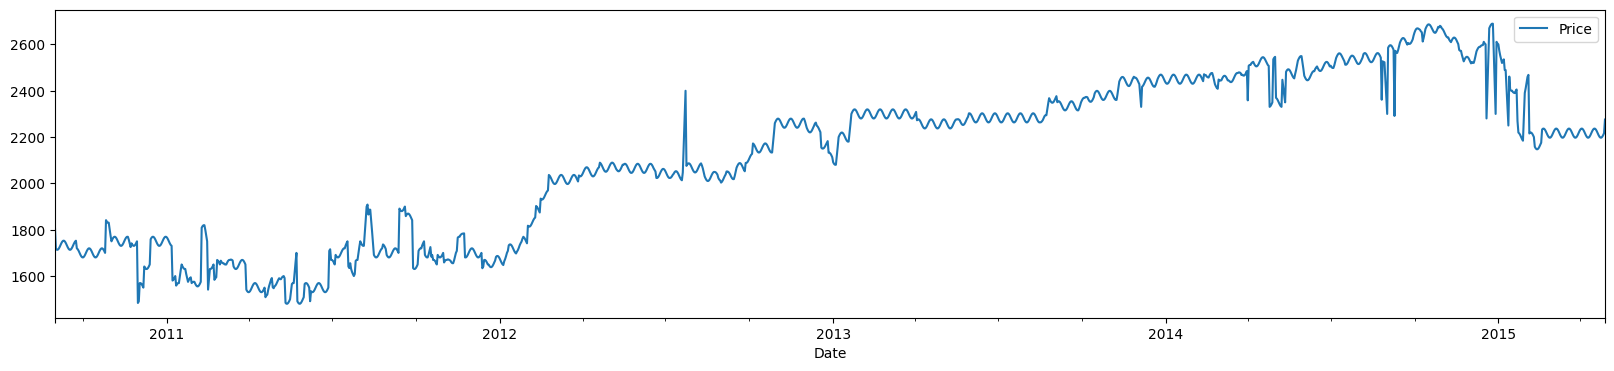

In [10]:
df.plot(figsize=(20, 4))

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
result = seasonal_decompose(df, model="multiplicative")

NameError: name 'seasonal_decompose' is not defined

In [ ]:
result.resid.plot(figsize=(8, 5))
plt.ylabel("Price Deviation")
plt.show()

NameError: name 'result' is not defined

In [13]:
PREDICTION_DAYS = 28

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

In [16]:
sequence_length = 56

In [17]:
X, y = [], []

sequences = []

for i in range(len(df) - sequence_length):
    X.append(scaled_data[i:(i + sequence_length)])
    y.append(scaled_data[(i + sequence_length)][0])

X = np.array(X)
y = np.array(y)

In [18]:
X.shape, y.shape

((1646, 56, 1), (1646,))

In [19]:
split = int(0.8 * len(X))

In [20]:
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

In [21]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential(
    [
        LSTM(units=64, return_sequences=True, activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units=64, return_sequences=False),
        Dense(units=1),
    ]
)

model.compile(optimizer="adam", loss="mean_squared_error")

2024-02-08 23:25:52.471371: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-08 23:25:52.515546: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 23:25:52.515615: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 23:25:52.517722: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-08 23:25:52.525686: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-08 23:25:52.526660: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 56, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 49985 (195.25 KB)
Trainable params: 49985 (195.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
history = model.fit(X_train, y_train, batch_size=28, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50


47/47 [==============================] - 4s 39ms/step - loss: 0.0362 - val_loss: 0.0063
Epoch 2/50
47/47 [==============================] - 1s 29ms/step - loss: 0.0019 - val_loss: 0.0035
Epoch 3/50
47/47 [==============================] - 1s 28ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 4/50
47/47 [==============================] - 1s 29ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 5/50
47/47 [==============================] - 1s 28ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 6/50
47/47 [==============================] - 1s 28ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 7/50
47/47 [==============================] - 1s 27ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 8/50
47/47 [==============================] - 1s 29ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 9/50
47/47 [==============================] - 1s 28ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 10/50
47/47 [==============================] - 1s 28ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 11/50
47/47 [=

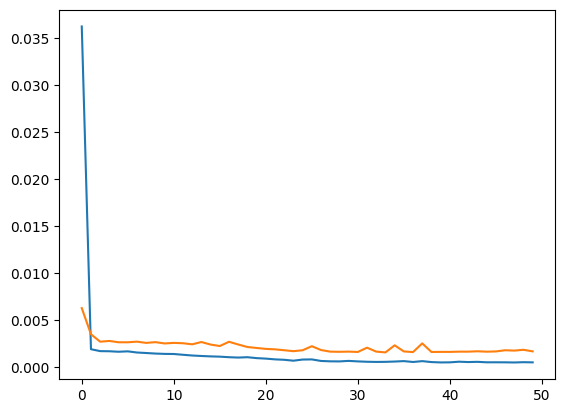

In [24]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [25]:
from joblib import dump, load

In [26]:
# model = load("./out/forecast.LSTM.Nagpur.Rice.joblib")

In [27]:
x_test = scaled_data[-sequence_length:]
x_test = np.array([x_test])

In [28]:
predictions = model.predict(X)

52/52 [==============================] - 1s 14ms/step


In [29]:
predictions = scaler.inverse_transform(predictions).flatten()

In [30]:
predictions.shape

(1646,)

In [31]:
from datetime import timedelta

In [32]:
future_dates = [df.index[-1] + timedelta(days=i) for i in range(1, 29)]

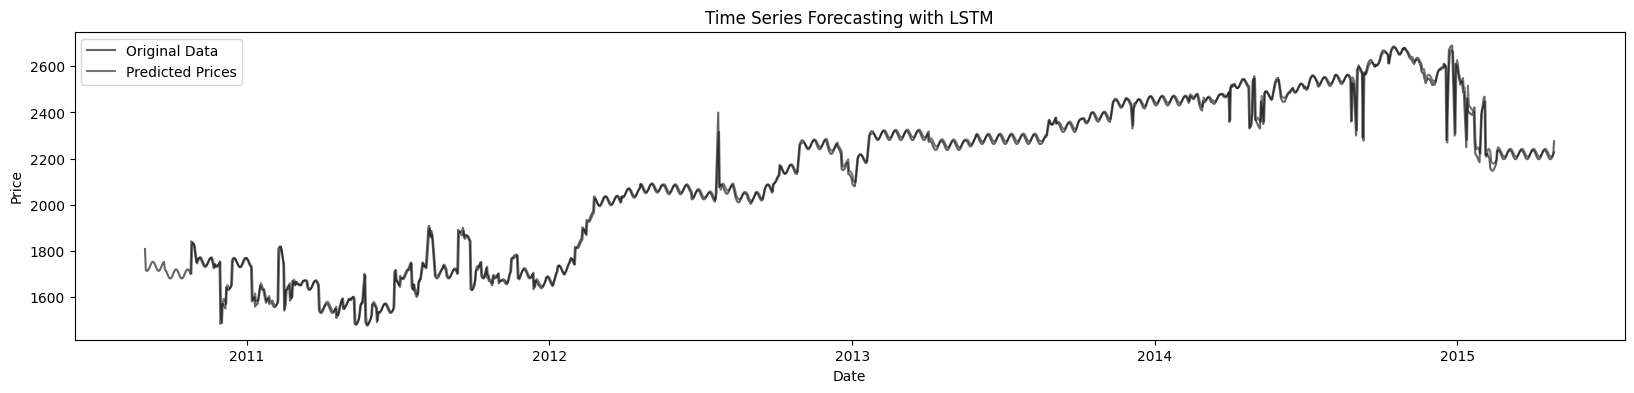

In [33]:
plt.figure(figsize=(20, 4))
plt.plot(df.index, df['Price'], label='Original Data', c="#666666")
plt.plot(df.index[sequence_length:], predictions, label='Predicted Prices', c="#00000088")
plt.title('Time Series Forecasting with LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [38]:
# dump(model, "./out/forecast.LSTM.Nagpur.Rice.joblib")
# dump(scaler, "./out/scaler.Nagpur.joblib")

['./out/scaler.Nagpur.joblib']

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

(
    mean_absolute_error(predictions, df["Price"][sequence_length:]),
    mean_squared_error(predictions, df["Price"][sequence_length:], squared=False),
)

/home/smv/Code/fresh-fields/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(14.712486267609377, 32.698956853807516)